<a href="https://colab.research.google.com/github/ADRIAN02-CODE/telco-churn-prediction/blob/main/telco_churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import joblib

# Keras / TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Optional SMOTE for class imbalance
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False

RANDOM_STATE = 42
TEST_SIZE = 0.2
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported.")


✅ Libraries imported.


In [2]:
EXCEL_PATHS = [
    'Telecom Dataset.xlsx',
    'Telecom Dataset .xlsx',
    '/content/Telecom Dataset.xlsx',
    '/content/Telecom Dataset .xlsx',
    'telco_customer_churn.xlsx',
    'WA_Fn-UseC_-Telco-Customer-Churn.csv'
]

data_loaded = False
for path in EXCEL_PATHS:
    if os.path.exists(path):
        if path.lower().endswith('.csv'):
            df = pd.read_csv(path)
        else:
            df = pd.read_excel(path, engine='openpyxl')
        print(f"✅ Loaded data from: {path} | shape: {df.shape}")
        data_loaded = True
        break

if not data_loaded:
    raise FileNotFoundError("❌ Dataset not found. Please upload the Telco dataset and set EXCEL_PATH correctly.")

print(df.columns.tolist())
df.head()


✅ Loaded data from: WA_Fn-UseC_-Telco-Customer-Churn.csv | shape: (7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  704

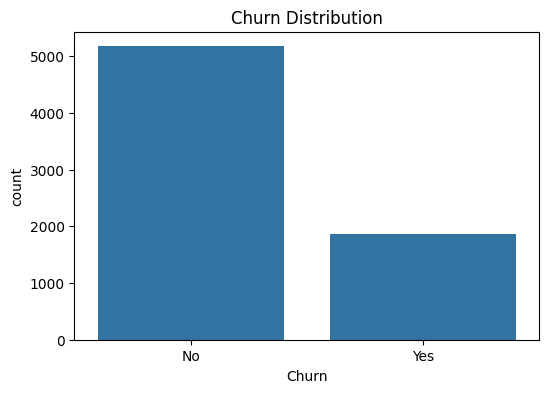

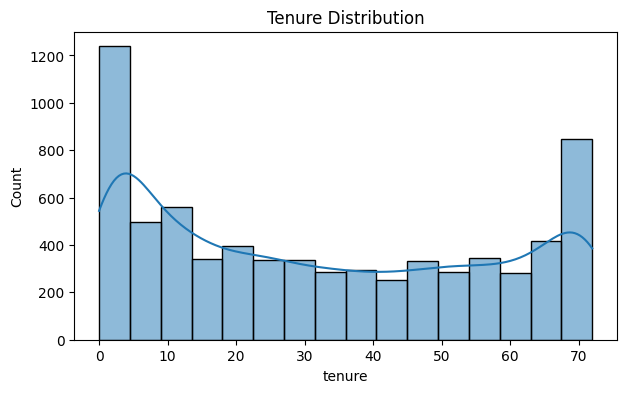

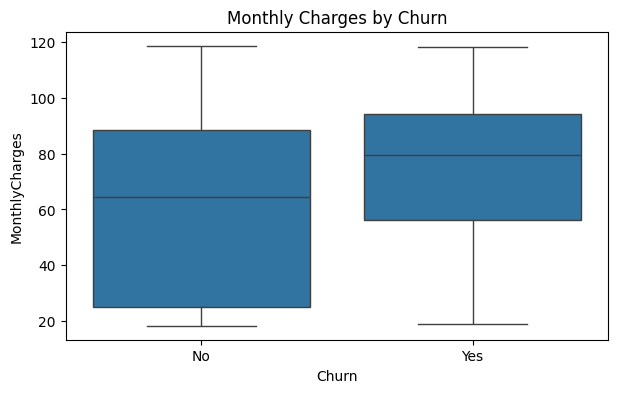

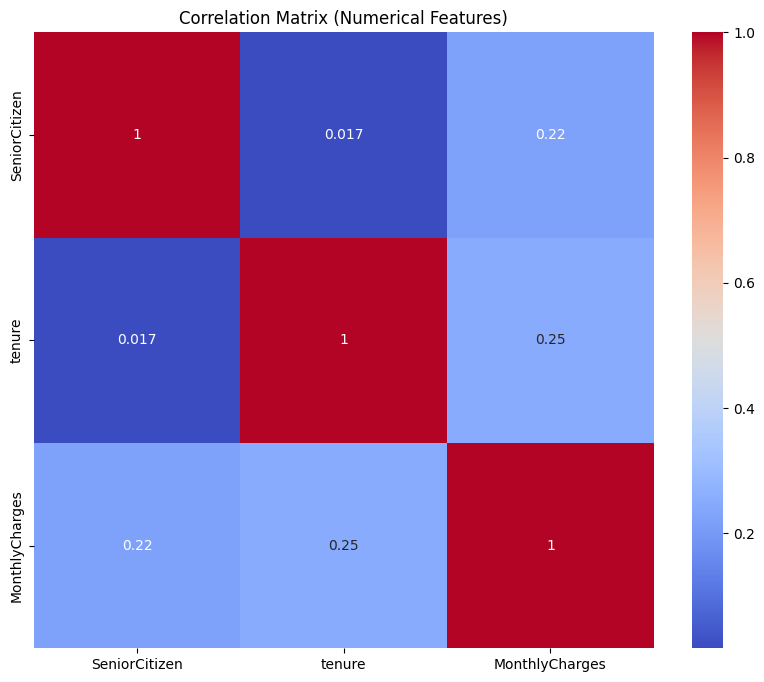

Missing values:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [3]:
print("--- Dataset Info ---")
print(df.info())

# Clean text: remove extra spaces in string columns
for col in df.select_dtypes(include=["object"]).columns:
    df[col] = df[col].astype(str).str.strip()

# 1) Churn distribution
plt.figure(figsize=(6, 4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution")
plt.show()

# 2) Tenure distribution
if "tenure" in df.columns:
    plt.figure(figsize=(7, 4))
    sns.histplot(df["tenure"].astype(float), kde=True)
    plt.title("Tenure Distribution")
    plt.show()

# 3) Monthly Charges vs Churn
if "MonthlyCharges" in df.columns:
    plt.figure(figsize=(7, 4))
    sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
    plt.title("Monthly Charges by Churn")
    plt.show()

# 4) Correlation heatmap for numeric variables
num_cols = df.select_dtypes(include=np.number)
if not num_cols.empty:
    plt.figure(figsize=(10, 8))
    sns.heatmap(num_cols.corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Matrix (Numerical Features)")
    plt.show()

print("Missing values:")
print(df.isnull().sum())


In [4]:
!git config --global user.name "ADRIAN02-CODE"
!git config --global user.email "adrianvethanayagam@gmail.com"


In [5]:
# ===== Preprocessing & feature engineering =====

# 1. Fix TotalCharges (convert from object to numeric; common issue)
if "TotalCharges" in df.columns:
    df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# 2. Drop customerID (identifier only, not predictive)
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# 3. Handle missing values (simple, consistent strategy)
df = df.dropna()

# 4. Encode target: Yes -> 1, No -> 0
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(int)

# 5. Split features and target
X = df.drop(columns=["Churn"])
y = df["Churn"]

# 6. One‑hot encode categorical features
X = pd.get_dummies(X, drop_first=True)

print("Shape after encoding:", X.shape)

# 7. Train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# 8. Optional SMOTE to address class imbalance
if IMBLEARN_AVAILABLE:
    smote = SMOTE(random_state=RANDOM_STATE)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
    print("SMOTE applied. New train shape:", X_train_res.shape)
else:
    X_train_res, y_train_res = X_train, y_train
    print("SMOTE not available; using original training set.")

# 9. Standardize features (for Neural Network)
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)


Shape after encoding: (7032, 30)
Train shape: (5625, 30) Test shape: (1407, 30)
SMOTE applied. New train shape: (8260, 30)


Fitting 5 folds for each of 90 candidates, totalling 450 fits
Best Decision Tree params: {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree accuracy: 0.7448471926083866

Decision Tree classification report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      1033
           1       0.52      0.64      0.57       374

    accuracy                           0.74      1407
   macro avg       0.69      0.71      0.70      1407
weighted avg       0.77      0.74      0.75      1407

Decision Tree confusion matrix:
 [[807 226]
 [133 241]]
Decision Tree ROC‑AUC: 0.7813905814019702


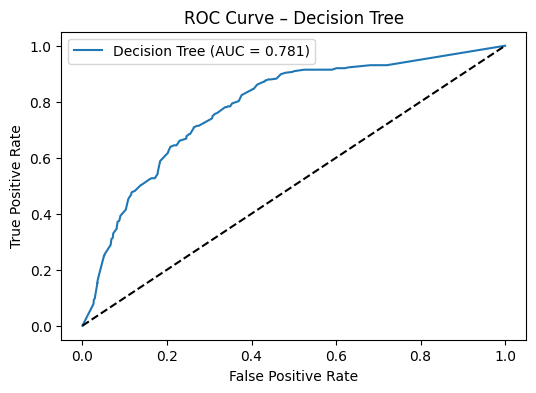

In [6]:
# ===== Decision Tree: training, tuning, evaluation =====

dt = DecisionTreeClassifier(random_state=RANDOM_STATE)

param_grid = {
    "max_depth": [3, 5, 7, 9, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}

grid_dt = GridSearchCV(
    dt,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train_res, y_train_res)

best_dt = grid_dt.best_estimator_
print("Best Decision Tree params:", grid_dt.best_params_)

# Evaluation
y_pred_dt = best_dt.predict(X_test)
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]

print("Decision Tree accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nDecision Tree classification report:\n", classification_report(y_test, y_pred_dt))

cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Decision Tree confusion matrix:\n", cm_dt)

roc_dt = roc_auc_score(y_test, y_proba_dt)
print("Decision Tree ROC‑AUC:", roc_dt)

# ROC curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
plt.figure(figsize=(6, 4))
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {roc_dt:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Decision Tree")
plt.legend()
plt.show()


Epoch 1/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6105 - loss: 0.6675 - val_accuracy: 0.6858 - val_loss: 0.6702
Epoch 2/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7619 - loss: 0.5054 - val_accuracy: 0.8136 - val_loss: 0.5037
Epoch 3/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7738 - loss: 0.4758 - val_accuracy: 0.8426 - val_loss: 0.4357
Epoch 4/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7926 - loss: 0.4497 - val_accuracy: 0.8414 - val_loss: 0.4417
Epoch 5/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7946 - loss: 0.4410 - val_accuracy: 0.8565 - val_loss: 0.3880
Epoch 6/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7959 - loss: 0.4395 - val_accuracy: 0.8420 - val_loss: 0.4090
Epoch 7/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7977 - loss: 0.4306 - val_accuracy: 0.8650 - val_loss: 0.3439
Epoch 8/50
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8048 - loss: 0.4186 - val_accuracy: 0.

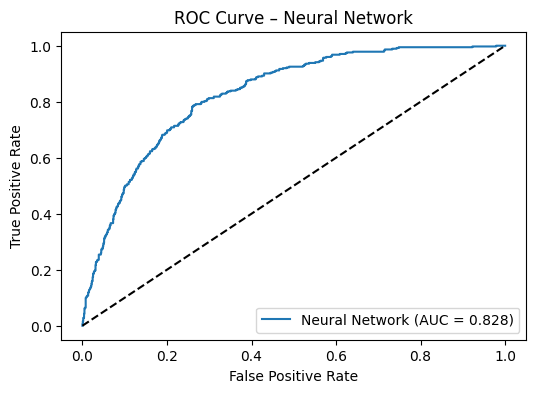

In [7]:
# ===== Neural Network: training & evaluation =====

input_dim = X_train_res_scaled.shape[1]

model = Sequential([
    Dense(64, activation="relu", input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(32, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_res_scaled,
    y_train_res,
    validation_split=0.2,
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_proba_nn = model.predict(X_test_scaled).ravel()
y_pred_nn = (y_proba_nn >= 0.5).astype(int)

print("Neural Network accuracy:", accuracy_score(y_test, y_pred_nn))
print("\nNeural Network classification report:\n", classification_report(y_test, y_pred_nn))

cm_nn = confusion_matrix(y_test, y_pred_nn)
print("Neural Network confusion matrix:\n", cm_nn)

roc_nn = roc_auc_score(y_test, y_proba_nn)
print("Neural Network ROC‑AUC:", roc_nn)

# ROC curve
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_proba_nn)
plt.figure(figsize=(6, 4))
plt.plot(fpr_nn, tpr_nn, label=f"Neural Network (AUC = {roc_nn:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Neural Network")
plt.legend()
plt.show()


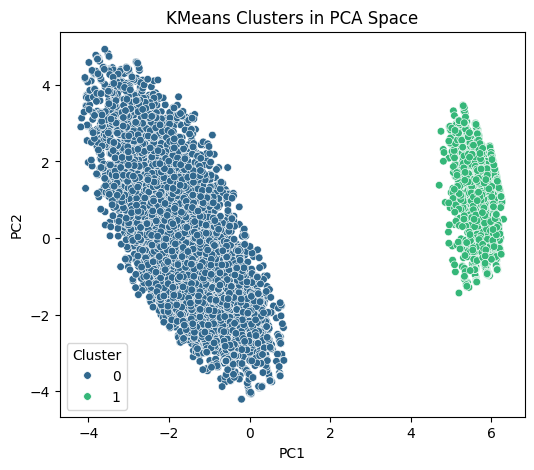

Cluster vs Churn:
 Churn     0     1
row_0            
0      3756  1756
1      1407   113


In [8]:
# ===== Optional: Unsupervised view with KMeans & PCA =====

# Use scaled full dataset for clustering
X_scaled_full = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_scaled_full)

pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled_full)

plt.figure(figsize=(6, 5))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=clusters,
    palette="viridis",
    s=30
)
plt.title("KMeans Clusters in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

# Compare clusters vs true churn
cluster_vs_churn = pd.crosstab(clusters, y)
print("Cluster vs Churn:\n", cluster_vs_churn)


In [9]:
# ===== Save models & scaler =====

os.makedirs("models", exist_ok=True)

joblib.dump(best_dt, "models/decision_tree_churn.pkl")
joblib.dump(scaler, "models/scaler.pkl")
model.save("models/neural_network_churn.h5")

print("Models and scaler saved in 'models' folder.")


Models and scaler saved in 'models' folder.


!git config --global user.name "Adrian02-CODE"
!git config --global user.email "adrianvethanayagam@gmail.com"
